# Reasoning Model Multi-Hop Comparison Report

This Jupyter notebook processes SEVAL job data and generates detailed multi-hop comparison reports on reasoning models across control and treatment experiments.

**Getting Started**: When you run the configuration cell (cell 4), you can modify the following settings:

1. **SEVAL Job ID** (e.g., '133560') – The job ID to analyze
2. **Data Paths** (optional) – Override the default paths if your SEVAL data is in a custom location:
   - `RAW_DATA_DIR` – Path to scraping raw data output
   - `METRICS_DIR` – Path to SEVAL metrics (CiteDCG labels)
3. **Top-k Values** – List of top-k values to analyze (e.g., [1, 3, 5]) for ranking metrics
4. **Clean Preprocessing** – Set `CLEAN_EXISTING = True` to force regeneration of preprocessing steps
 
**Default Data Structure**:
By default, the notebook expects data in the following structure:
```
seval_data/
  {job_id}_scraping_raw_data_output/    # Raw conversation data
  {job_id}_metrics/                      # CiteDCG metrics
```

You can override these paths if your data is located elsewhere (e.g., on a different drive or network location).

**What This Notebook Does**:
- Extracts CiteDCG scores from SEVAL metrics for both control and treatment
- Extracts conversation details and merges with CiteDCG scores
- Builds per-utterance statistics aggregated by hop index
- Creates comprehensive comparison plots showing:
  - Hop-by-hop score progression (including/excluding empty hops)
  - Single-hop vs multi-hop performance analysis
  - Control vs treatment experiment comparisons
- Exports detailed statistics to CSV for further analysis

**Prerequisites**: 
- SEVAL data must be downloaded and available locally (either in default location or custom path)

**Processing Behavior**:
- **Statistics plots are ALWAYS regenerated** for consistency and to reflect the latest data
- Preprocessing steps (CiteDCG extraction, conversation details, merged files) are reused by default for faster processing
- Set `CLEAN_EXISTING = True` to force complete regeneration of all preprocessing steps from scratch

**Output**: All results are saved to `results/{job_id}_statistics_plots/` including:
- Statistics JSON files with hop-level aggregations
- PNG plot images for visualization
- CSV exports for Excel/data analysis


In [9]:
# Automatically reload modules before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

  %reload_ext autoreload


In [10]:
import os
import sys
import json
from pathlib import Path
from IPython.display import display, Markdown, Image

# Add the seval directory to the path
seval_dir = Path.cwd()
if str(seval_dir) not in sys.path:
    sys.path.insert(0, str(seval_dir))

print("✓ Modules loaded successfully")

✓ Modules loaded successfully



In [11]:
# Configuration - Modify these values as needed
JOB_ID = "133560"
TOP_K_LIST = [1, 3, 5]  # Top-k values to analyze
THREADS = 16
CLEAN_EXISTING = False  # Set to True to regenerate preprocessing steps (CiteDCG, conversations, merged)
                         # Note: Statistics plots are ALWAYS regenerated

# Base directories
BASE_DIR = Path.cwd()
RESULTS_DIR = BASE_DIR / "results"

# SEVAL Data Paths - Override these if your data is in a different location
# Default paths assume standard directory structure:
#   seval_data/{job_id}_scraping_raw_data_output/
#   seval_data/{job_id}_metrics/
RAW_DATA_DIR = BASE_DIR / "seval_data" / f"{JOB_ID}_scraping_raw_data_output"
METRICS_DIR = BASE_DIR / "seval_data" / f"{JOB_ID}_metrics"

# Example: Override paths if data is located elsewhere
# RAW_DATA_DIR = Path("C:/my_data/seval/133560_scraping_raw_data_output")
# METRICS_DIR = Path("C:/my_data/seval/133560_metrics")

print(f"Configuration:")
print(f"  Job ID: {JOB_ID}")
print(f"  Experiment: both (control + treatment)")
print(f"  Top-k values: {TOP_K_LIST}")
print(f"  Raw data directory: {RAW_DATA_DIR}")
print(f"  Metrics directory: {METRICS_DIR}")
print(f"  Output directory: {RESULTS_DIR}")
print(f"  Clean preprocessing: {CLEAN_EXISTING}")
print()

# Verify paths exist
if not RAW_DATA_DIR.exists():
    print(f"⚠ Warning: Raw data directory not found: {RAW_DATA_DIR}")
if not METRICS_DIR.exists():
    print(f"⚠ Warning: Metrics directory not found: {METRICS_DIR}")
if RAW_DATA_DIR.exists() and METRICS_DIR.exists():
    print("✓ Data directories found")


Configuration:
  Job ID: 133560
  Experiment: both (control + treatment)
  Top-k values: [1, 3, 5]
  Raw data directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
  Metrics directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
  Output directory: c:\working\BizChatScripts\projects\seval\results
  Clean preprocessing: False
  Job ID: 133560
  Experiment: both (control + treatment)
  Top-k values: [1, 3, 5]
  Raw data directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
  Metrics directory: c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
  Output directory: c:\working\BizChatScripts\projects\seval\results
  Clean preprocessing: False

✓ Data directories found


✓ Data directories found


## Step 1: Run Full SEVAL Processing Pipeline

This will execute all steps:
1. Extract CiteDCG scores from metrics (reused if CLEAN_EXISTING=False)
2. Extract conversation details from raw data (reused if CLEAN_EXISTING=False)
3. Merge CiteDCG scores with conversations (reused if CLEAN_EXISTING=False)
4. Build per-utterance details with hop-level scores (reused if CLEAN_EXISTING=False)
5. Generate statistics and plots (ALWAYS regenerated)

**Output Control**:
- The pipeline runs with `verbose=False` for a clean notebook experience
- Only essential progress messages are shown (what's being processed, completion status)
- Detailed processing logs are suppressed (file counts, threading details, etc.)
- To see full logs for debugging, change `verbose=False` to `verbose=True` in the cell below


In [ ]:
# Run the pipeline with minimal output for notebook
print("="*80)
print(f"SEVAL JOB PROCESSING: {JOB_ID} (Control + Treatment)")
print("="*80)
print()

# Always clean the statistics plots directory
import shutil

stats_dir = RESULTS_DIR / f"{JOB_ID}_statistics_plots"

if stats_dir.exists():
    print(f"Cleaning statistics plots directory: {stats_dir}")
    shutil.rmtree(stats_dir)
    print("✓ Old plots and statistics deleted")
    print()

# Import and run the full pipeline
from seval_batch_processor import process_seval_job_with_statistics_plots

# Run the full pipeline
# verbose=False: Shows only essential progress messages (for notebook/end users)
# verbose=True: Shows detailed processing logs (for batch processing/developers)
# clean parameter controls whether to reuse preprocessing (CiteDCG, conversations, merged)
result = process_seval_job_with_statistics_plots(
    job_id=JOB_ID,
    experiment="both",
    top_k_list=TOP_K_LIST,
    raw_data_dir=str(RAW_DATA_DIR),
    metrics_dir=str(METRICS_DIR),
    output_base_dir=str(RESULTS_DIR),
    threads=THREADS,
    verbose=False,  # Minimal output for notebook users
    clean=CLEAN_EXISTING
)

print()
print("="*80)
print("✓ PROCESSING COMPLETE - READY TO DISPLAY RESULTS")
print("="*80)


SEVAL JOB PROCESSING: 133560 (Control + Treatment)

Cleaning statistics plots directory: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots
✓ Old plots and statistics deleted
SEVAL JOB PROCESSING: 133560 (Control + Treatment)

Cleaning statistics plots directory: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots
✓ Old plots and statistics deleted

SEVAL JOB PROCESSING WITH MULTIPLE TOP-K VALUES: 133560
Raw data:      c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
Metrics:       seval_data/c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
Experiment:    both

SEVAL JOB PROCESSING WITH MULTIPLE TOP-K VALUES: 133560
Raw data:      c:\working\BizChatScripts\projects\seval\seval_data\133560_scraping_raw_data_output
Metrics:       seval_data/c:\working\BizChatScripts\projects\seval\seval_data\133560_metrics
Experiment:    both
Top-k values:  [1, 3, 5]
Threads:       16
Clean existing: False


T

## Step 2: Display Generated Statistics

View the statistics for each experiment and top-k value.

In [13]:
# Display statistics summary
stats_dir = RESULTS_DIR / f"{JOB_ID}_statistics_plots"

def display_stats_summary(stats_file):
    """Display summary statistics from a stats JSON file."""
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    print(f"\nStatistics from: {stats_file.name}")
    print("="*60)
    print(f"Top-k: {stats.get('top_k')}")
    print(f"Total utterances: {stats.get('total_utterances')}")
    print(f"Utterances with scores: {stats.get('utterances_with_scores')}")
    
    # Per-hop statistics
    per_hop = stats.get('per_hop', {})
    if per_hop:
        print(f"\nPer-Hop Statistics (first 5 hops):")
        for hop in sorted([int(h) for h in per_hop.keys()])[:5]:
            hop_data = per_hop[str(hop)]
            avg = hop_data.get('avg_all_scores')
            count = hop_data.get('utterances_with_scores', 0)
            avg_str = f"{avg:.4f}" if avg is not None else "N/A"
            print(f"  Hop {hop}: avg={avg_str}, count={count}")
    
    # Single vs Multi-hop
    single = stats.get('single_hop', {})
    multi = stats.get('multi_hop', {})
    if single:
        single_data = single.get('1', {})
        print(f"\nSingle-hop utterances: {single_data.get('utterances_count', 0)}")
        print(f"  Avg score: {single_data.get('avg_all_scores', 0):.4f}")
    if multi:
        multi_count = sum(h.get('utterances_count', 0) for h in multi.values())
        print(f"Multi-hop utterances: {multi_count}")

# Display stats for each experiment and k-value
if stats_dir.exists():
    for stats_file in sorted(stats_dir.glob("*_plot_stats_k*.json")):
        display_stats_summary(stats_file)
else:
    print(f"Statistics directory not found: {stats_dir}")



Statistics from: 133560_control_plot_stats_k1.json
Top-k: 1
Total utterances: 1309
Utterances with scores: 979

Per-Hop Statistics (first 5 hops):
Top-k: 1
Total utterances: 1309
Utterances with scores: 979

Per-Hop Statistics (first 5 hops):
  Hop 1: avg=1.2103, count=906
  Hop 2: avg=1.2121, count=313
  Hop 3: avg=1.3845, count=132
  Hop 4: avg=1.3445, count=69
  Hop 5: avg=1.5153, count=52

Single-hop utterances: 661
  Avg score: 1.2744
  Hop 1: avg=1.2103, count=906
  Hop 2: avg=1.2121, count=313
  Hop 3: avg=1.3845, count=132
  Hop 4: avg=1.3445, count=69
  Hop 5: avg=1.5153, count=52

Single-hop utterances: 661
  Avg score: 1.2744
Multi-hop utterances: 971

Statistics from: 133560_control_plot_stats_k3.json

Multi-hop utterances: 971

Statistics from: 133560_control_plot_stats_k3.json
Top-k: 3
Total utterances: 1309
Utterances with scores: 979

Per-Hop Statistics (first 5 hops):
  Hop 1: avg=1.2103, count=906
  Hop 2: avg=1.2121, count=313Top-k: 3
Total utterances: 1309
Utteranc

## Step 3: Display Generated Plots

View the comparison plots generated by the pipeline.


133560_comparison_by_hop_index.png



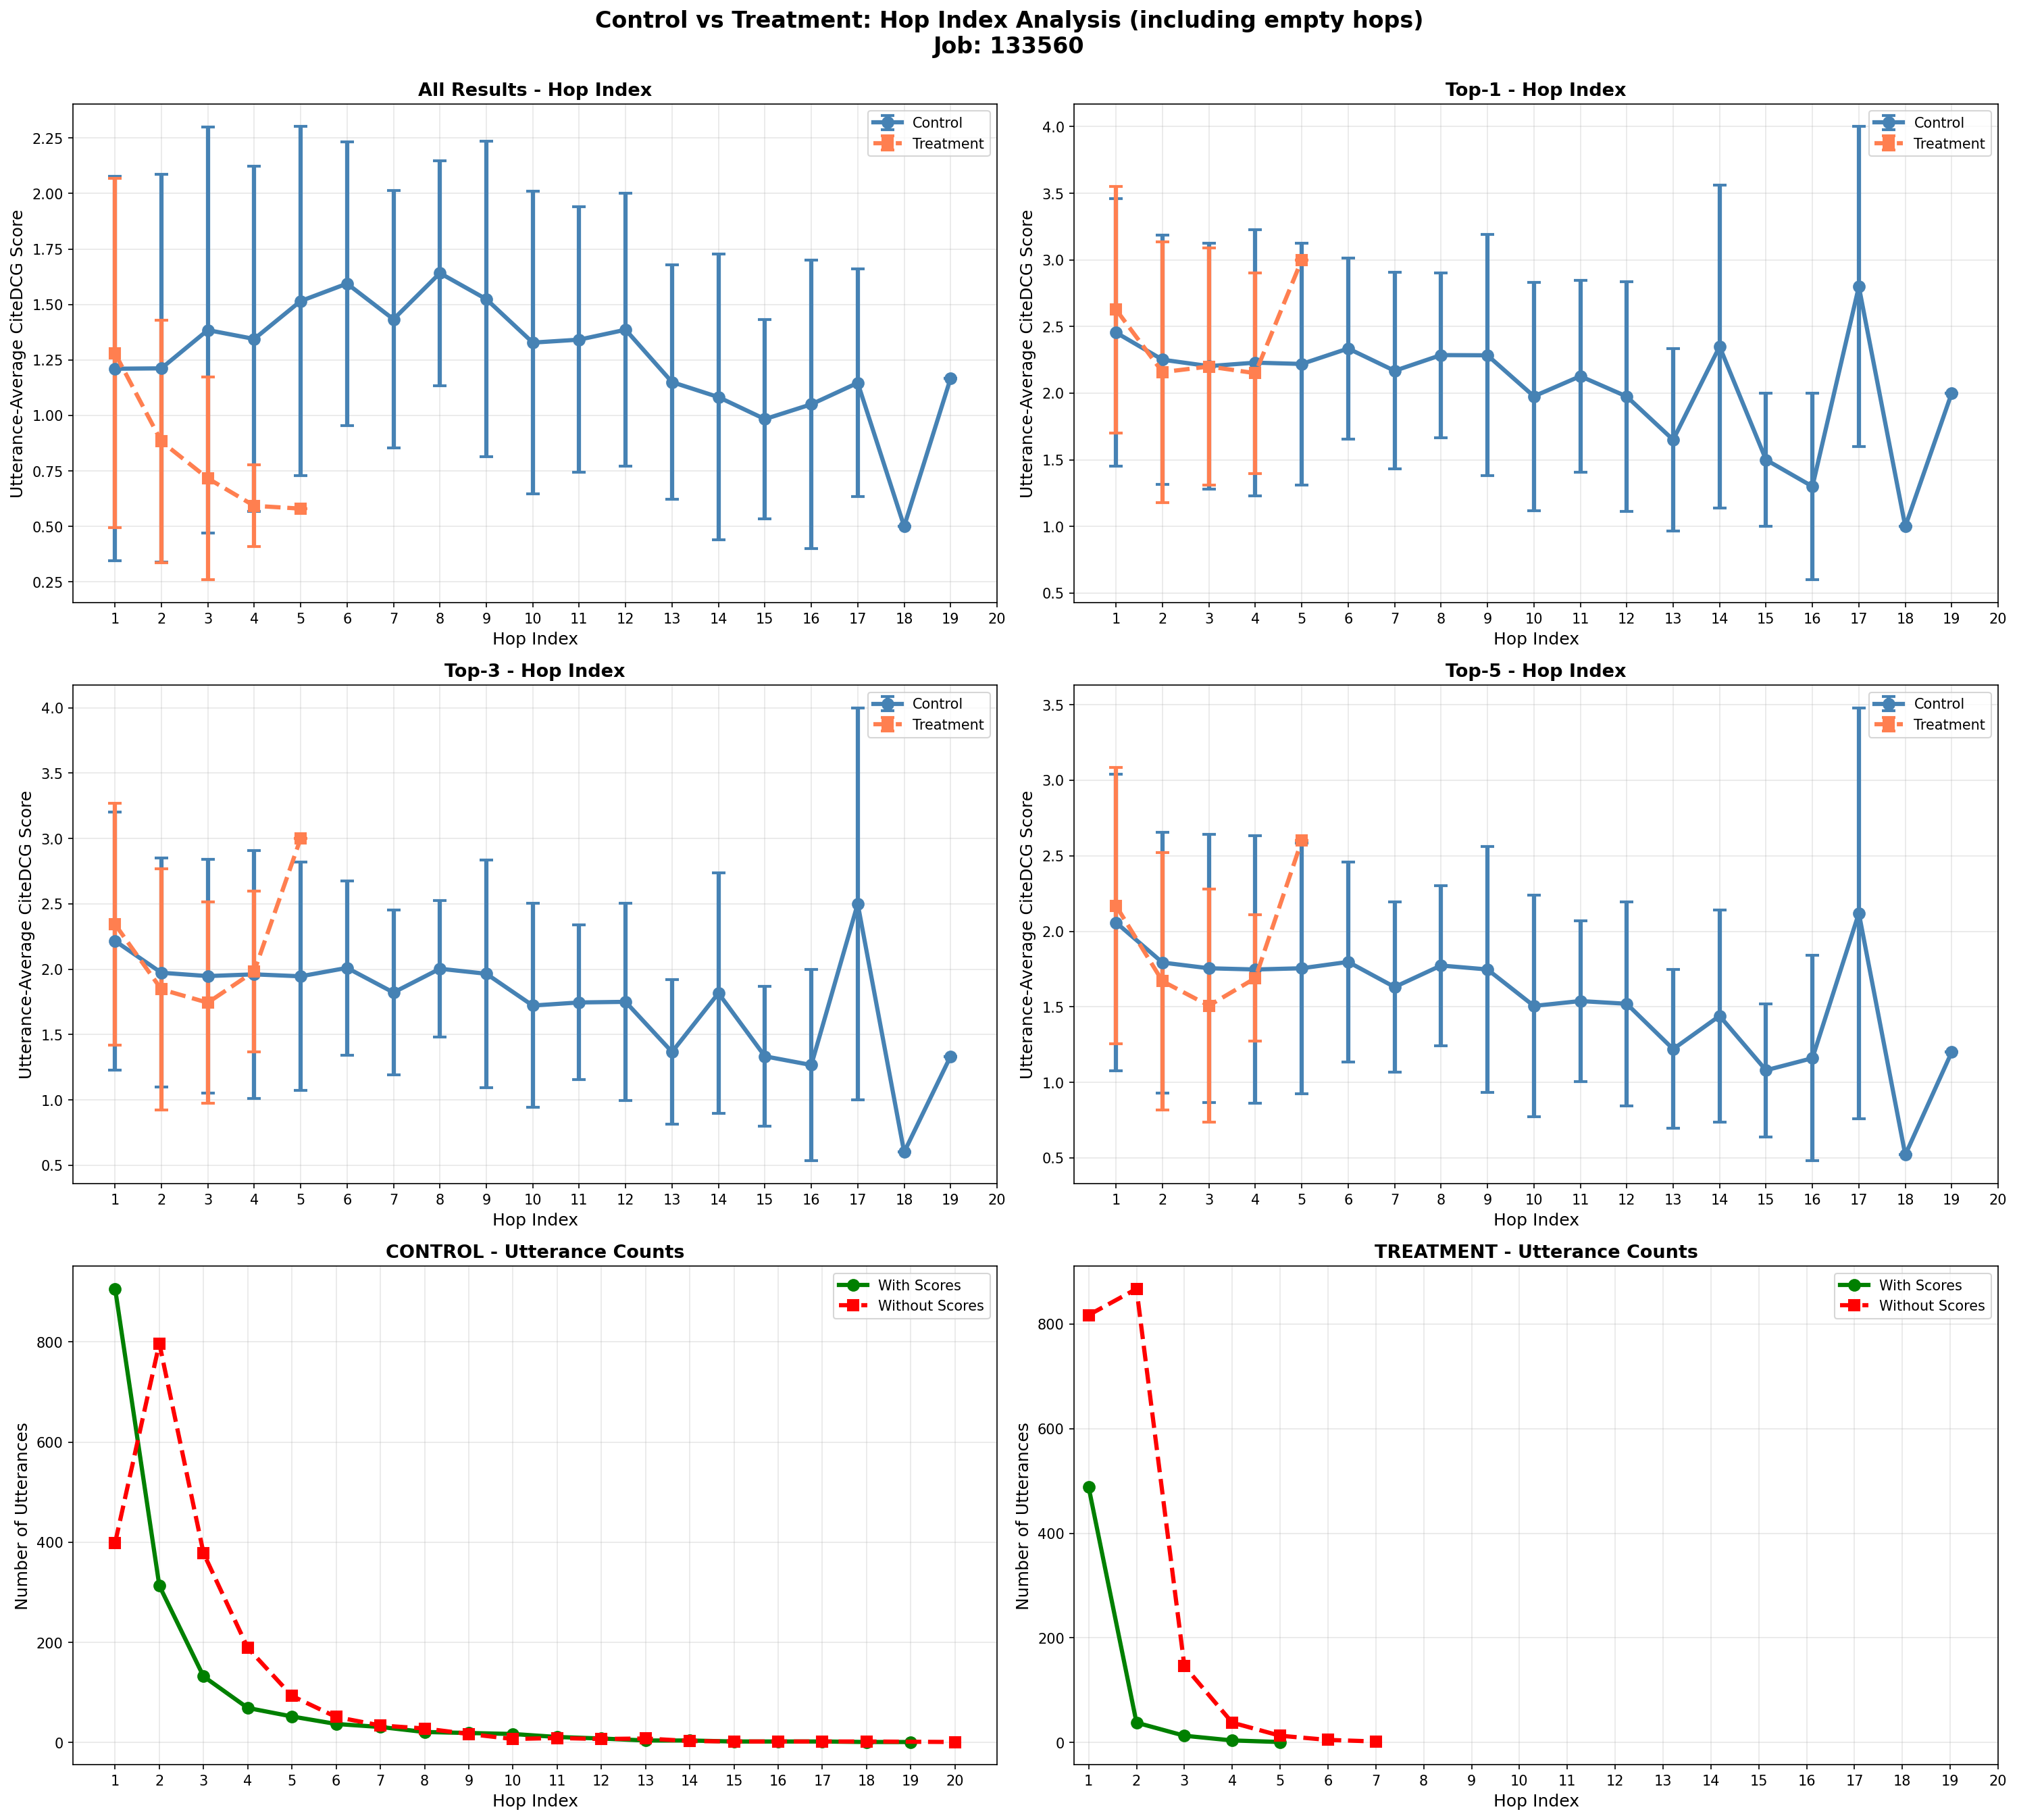


133560_comparison_by_hop_sequence.png



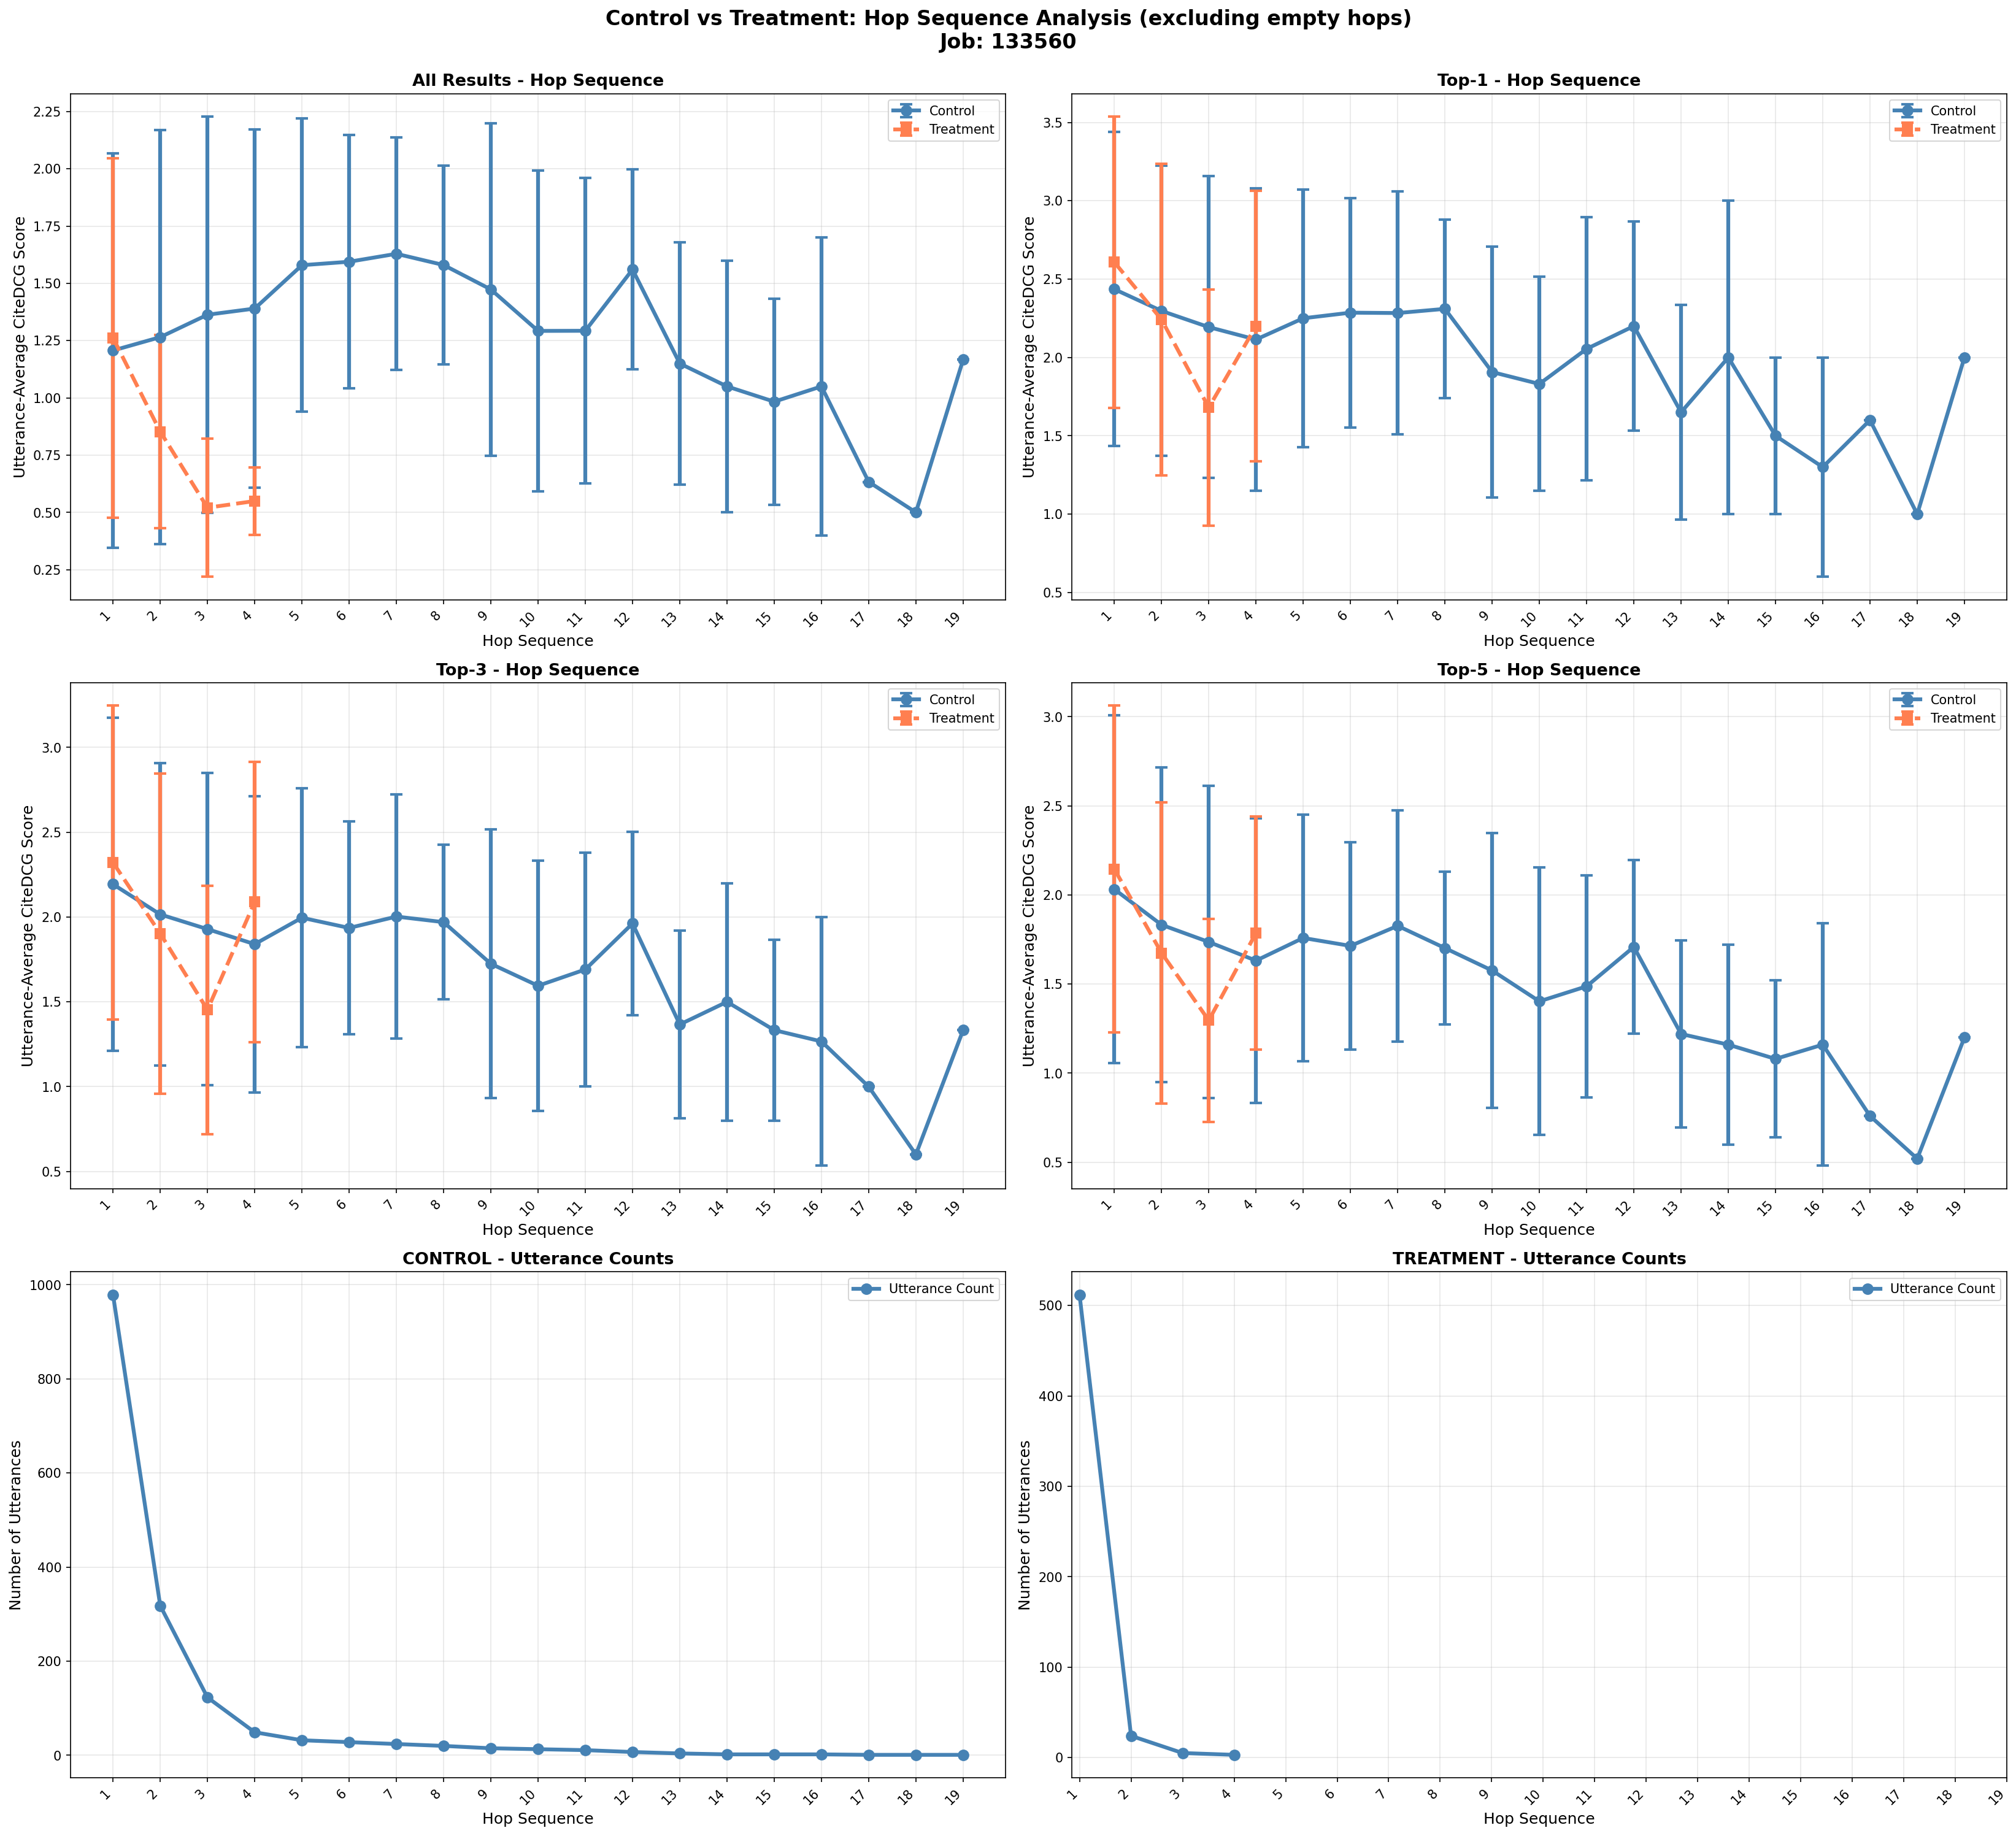


133560_comparison_single_vs_multi_hop.png



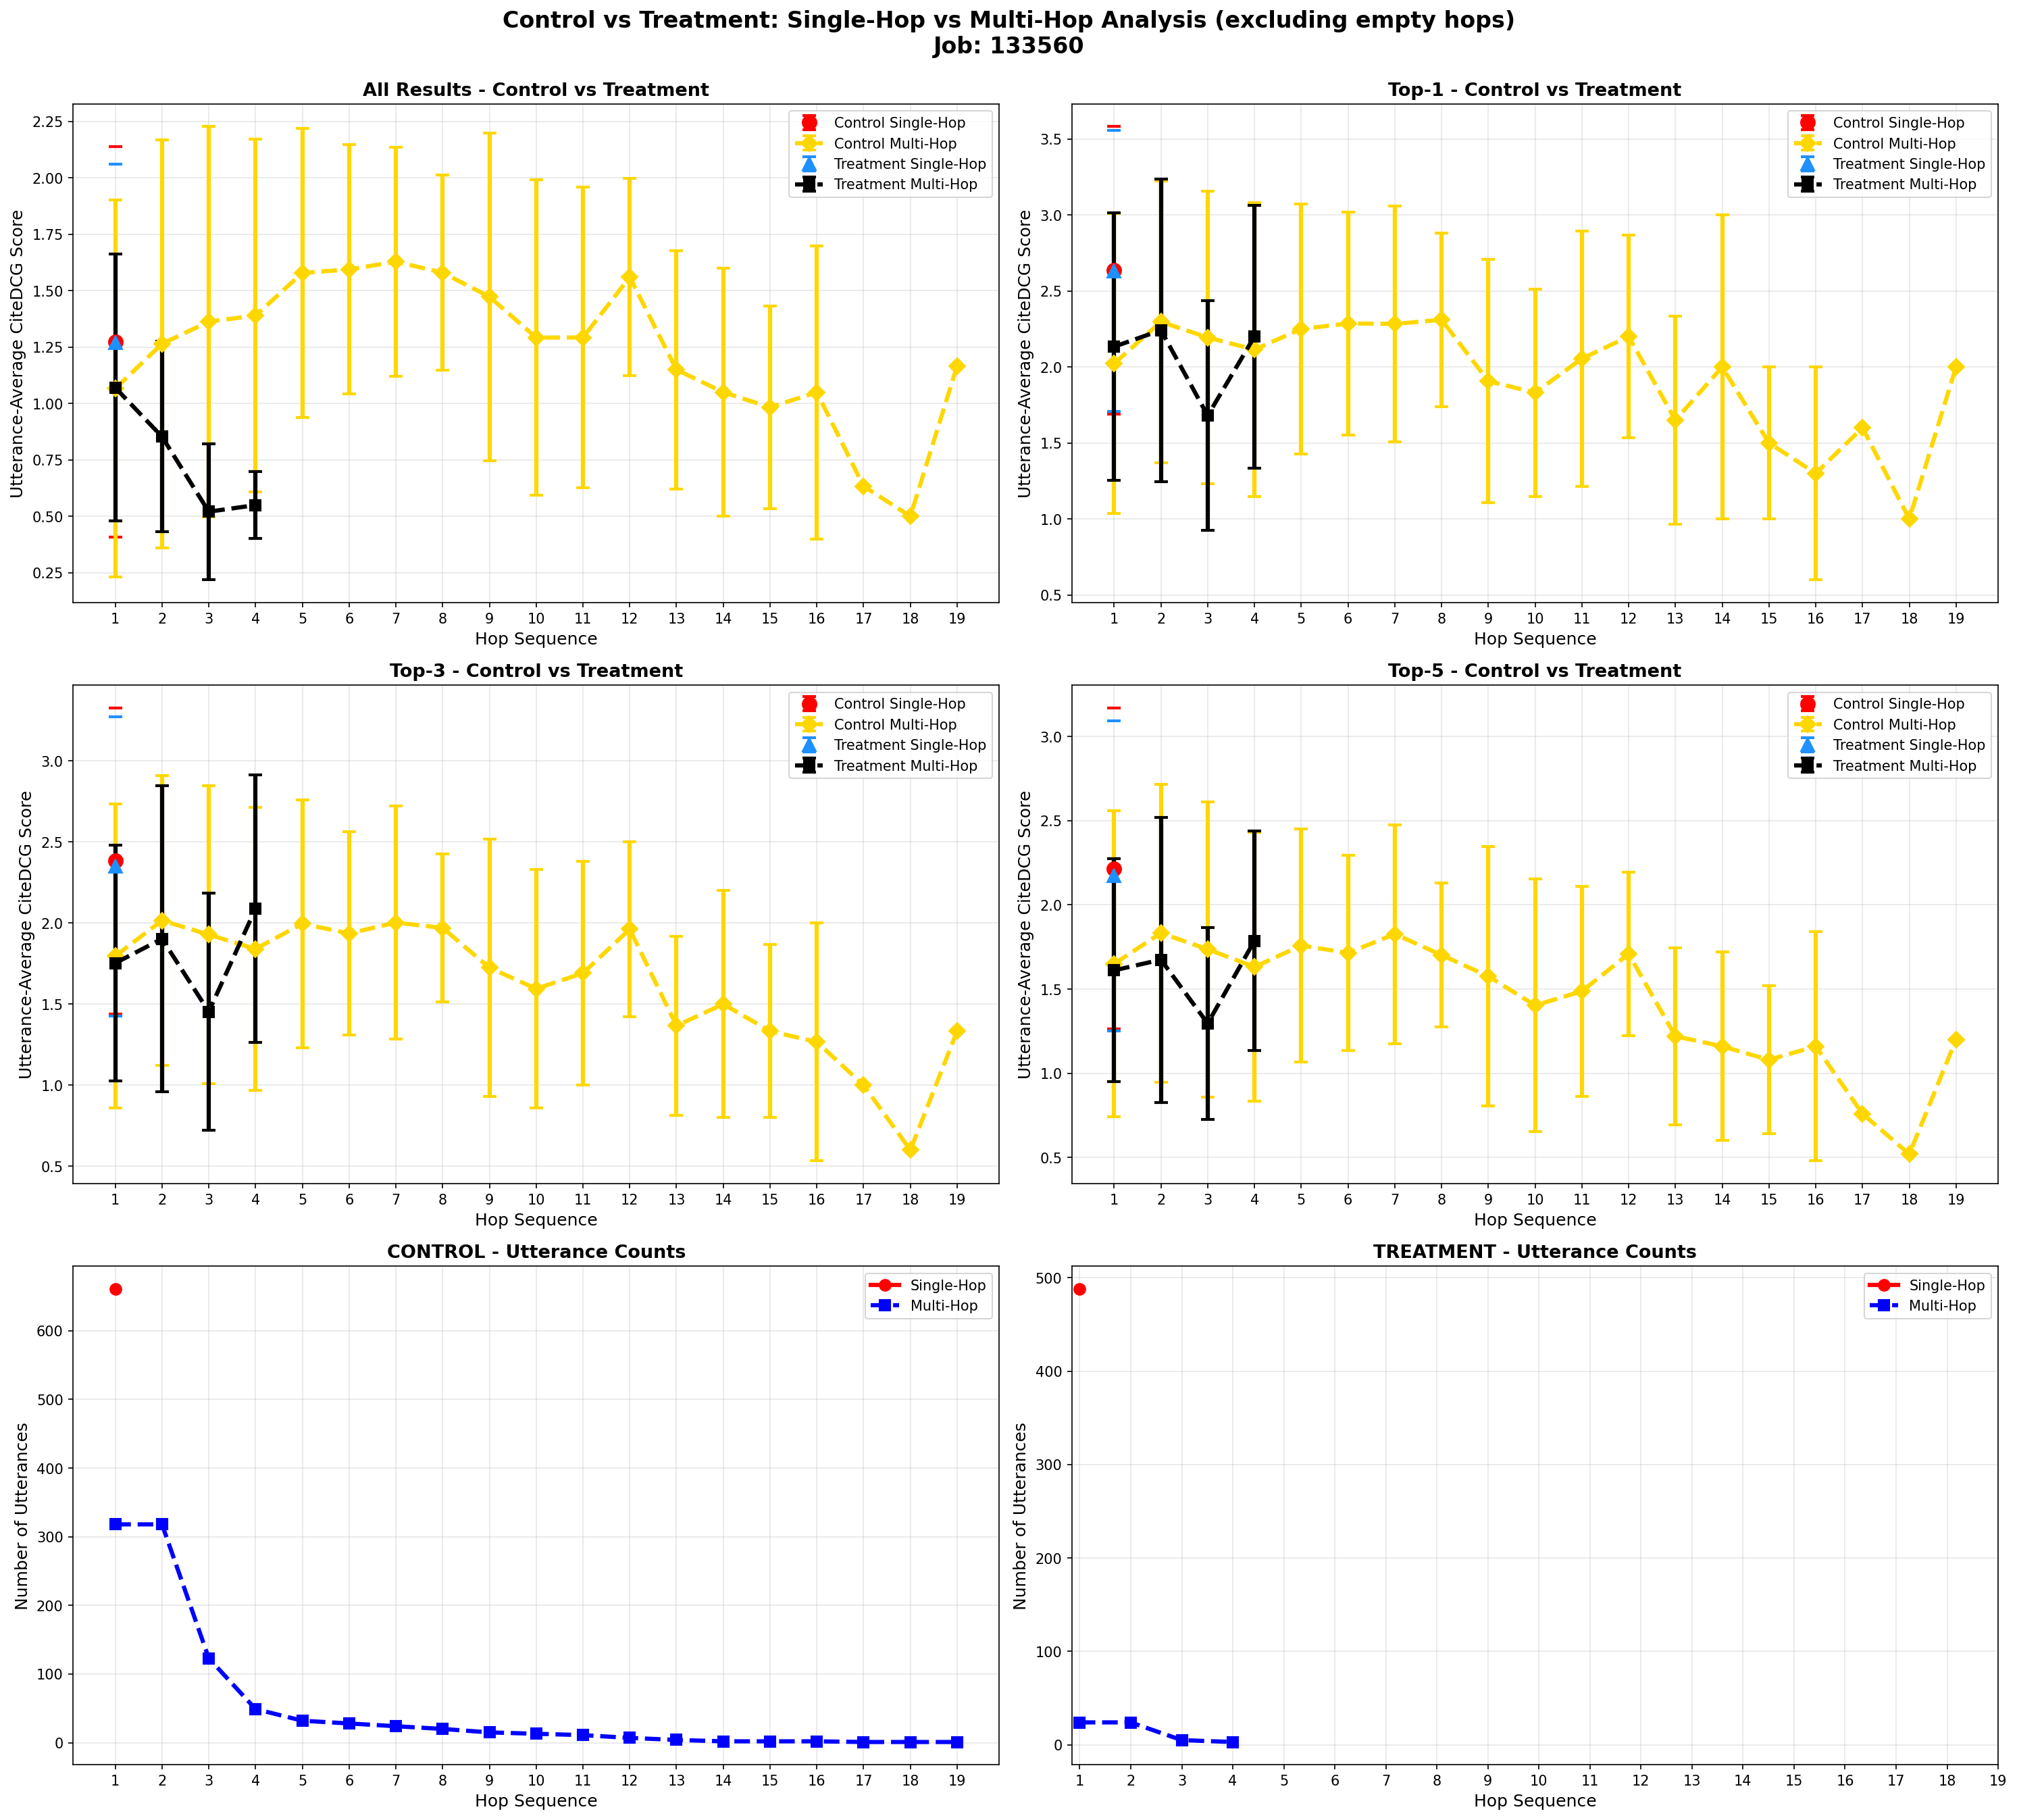

In [14]:
# Display generated plots (excluding paired utterances plot)
if stats_dir.exists():
    # Get all plots except the paired utterances plot
    all_plots = sorted(stats_dir.glob("*.png"))
    plot_files = [p for p in all_plots if 'paired' not in p.name.lower()]
    
    for plot_file in plot_files:
        print(f"\n{plot_file.name}")
        print("="*60)
        display(Image(filename=str(plot_file)))
else:
    print(f"Plots directory not found: {stats_dir}")

## Step 4: Detailed Statistics Analysis

Examine specific statistics in detail.

In [15]:
# Load and analyze specific statistics
def analyze_hop_statistics(experiment, k_value):
    """Analyze hop-level statistics for a specific experiment and k-value."""
    stats_file = stats_dir / f"{JOB_ID}_{experiment}_plot_stats_k{k_value}.json"
    
    if not stats_file.exists():
        print(f"Stats file not found: {stats_file}")
        return
    
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    print(f"\nDetailed Hop Statistics: {experiment.upper()} (k={k_value})")
    print("="*80)
    
    per_hop = stats.get('per_hop', {})
    
    # Create summary table
    print(f"{'Hop':<6} {'Avg Score':<12} {'Std Dev':<12} {'With Scores':<15} {'Without Scores':<15} {'Total':<10}")
    print("-"*80)
    
    for hop in sorted([int(h) for h in per_hop.keys()]):
        hop_data = per_hop[str(hop)]
        avg = hop_data.get('avg_all_scores')
        std = hop_data.get('std_all_scores')
        with_scores = hop_data.get('utterances_with_scores', 0)
        without_scores = hop_data.get('utterances_without_scores', 0)
        total = hop_data.get('total_utterances', 0)
        
        avg_str = f"{avg:.4f}" if avg is not None else "N/A"
        std_str = f"{std:.4f}" if std is not None else "N/A"
        
        print(f"{hop:<6} {avg_str:<12} {std_str:<12} {with_scores:<15} {without_scores:<15} {total:<10}")

# Analyze statistics for both control and treatment experiments
experiments = ['control', 'treatment']
for exp in experiments:
    for k in TOP_K_LIST:
        analyze_hop_statistics(exp, k)


Detailed Hop Statistics: CONTROL (k=1)
Hop    Avg Score    Std Dev      With Scores     Without Scores  Total     
--------------------------------------------------------------------------------
1      1.2103       0.8661       906             399             1305      
2      1.2121       0.8732       313             797             1110      
3      1.3845       0.9153       132             378             510       

Hop    Avg Score    Std Dev      With Scores     Without Scores  Total     
--------------------------------------------------------------------------------
1      1.2103       0.8661       906             399             1305      
2      1.2121       0.8732       313             797             1110      
3      1.3845       0.9153       132             378             510       
4      1.3445       0.7772       69              189             258       
5      1.5153       0.7860       52              93              145       
6      1.5939       0.6388       37  

## Step 5: Export Statistics to CSV (Optional)

Export statistics to CSV format for further analysis in Excel or other tools.

In [16]:
import pandas as pd

def export_statistics_to_csv(experiment, k_value):
    """Export hop statistics to CSV."""
    stats_file = stats_dir / f"{JOB_ID}_{experiment}_plot_stats_k{k_value}.json"
    
    if not stats_file.exists():
        print(f"Stats file not found: {stats_file}")
        return
    
    with open(stats_file, 'r', encoding='utf-8') as f:
        stats = json.load(f)
    
    per_hop = stats.get('per_hop', {})
    
    # Create DataFrame
    rows = []
    for hop in sorted([int(h) for h in per_hop.keys()]):
        hop_data = per_hop[str(hop)]
        rows.append({
            'Hop': hop,
            'Avg_All_Scores': hop_data.get('avg_all_scores'),
            'Std_All_Scores': hop_data.get('std_all_scores'),
            'Avg_TopK_Scores': hop_data.get('avg_topk_scores'),
            'Std_TopK_Scores': hop_data.get('std_topk_scores'),
            'Utterances_With_Scores': hop_data.get('utterances_with_scores', 0),
            'Utterances_Without_Scores': hop_data.get('utterances_without_scores', 0),
            'Total_Utterances': hop_data.get('total_utterances', 0)
        })
    
    df = pd.DataFrame(rows)
    
    # Save to CSV
    csv_file = stats_dir / f"{JOB_ID}_{experiment}_hop_stats_k{k_value}.csv"
    df.to_csv(csv_file, index=False)
    print(f"✓ Exported to: {csv_file}")
    
    return df

# Export for all experiments and k-values
for exp in experiments:
    for k in TOP_K_LIST:
        df = export_statistics_to_csv(exp, k)
        if df is not None:
            display(Markdown(f"### {exp.upper()} - Top-{k}"))
            display(df.head(10))

✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k1.csv



### CONTROL - Top-1

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.210278,0.866055,2.454636,1.003716,906,399,1305
1,2,1.212087,0.873181,2.251118,0.933580,313,797,1110
2,3,1.384500,0.915261,2.203030,0.924083,132,378,510
3,4,1.344545,0.777237,2.228986,0.999290,69,189,258
4,5,1.515258,0.786039,2.219231,0.906608,52,93,145
5,6,1.593949,0.638822,2.335135,0.680308,37,51,88
6,7,1.433203,0.580994,2.167742,0.738083,31,34,65
7,8,1.641270,0.507604,2.285714,0.618974,21,28,49
8,9,1.523844,0.710773,2.284211,0.904528,19,17,36
9,10,1.328123,0.682360,1.976471,0.856484,17,7,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k3.csv



### CONTROL - Top-3

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.210278,0.866055,2.216519,0.986266,906,399,1305
1,2,1.212087,0.873181,1.972630,0.876661,313,797,1110
2,3,1.384500,0.915261,1.947222,0.895519,132,378,510
3,4,1.344545,0.777237,1.960386,0.949570,69,189,258
4,5,1.515258,0.786039,1.945513,0.872099,52,93,145
5,6,1.593949,0.638822,2.009910,0.666616,37,51,88
6,7,1.433203,0.580994,1.821505,0.628906,31,34,65
7,8,1.641270,0.507604,2.003175,0.522702,21,28,49
8,9,1.523844,0.710773,1.964912,0.869864,19,17,36
9,10,1.328123,0.682360,1.721569,0.780560,17,7,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_control_hop_stats_k5.csv



### CONTROL - Top-5

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.210278,0.866055,2.057781,0.980801,906,399,1305
1,2,1.212087,0.873181,1.792982,0.862907,313,797,1110
2,3,1.384500,0.915261,1.755202,0.888296,132,378,510
3,4,1.344545,0.777237,1.747246,0.886157,69,189,258
4,5,1.515258,0.786039,1.755256,0.829117,52,93,145
5,6,1.593949,0.638822,1.797297,0.661402,37,51,88
6,7,1.433203,0.580994,1.630968,0.562823,31,34,65
7,8,1.641270,0.507604,1.773333,0.530133,21,28,49
8,9,1.523844,0.710773,1.747368,0.814195,19,17,36
9,10,1.328123,0.682360,1.505882,0.735511,17,7,24


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k1.csv



### TREATMENT - Top-1

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.280650,0.786798,2.626639,0.925873,488,817,1305
1,2,0.882689,0.545173,2.157895,0.979966,38,867,905
2,3,0.716470,0.456997,2.200000,0.890980,13,146,159
3,4,0.592593,0.183592,2.150000,0.753326,4,38,42
4,5,0.580000,0.000000,3.000000,0.000000,1,13,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k3.csv



### TREATMENT - Top-3

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.280650,0.786798,2.344331,0.923632,488,817,1305
1,2,0.882689,0.545173,1.845614,0.920984,38,867,905
2,3,0.716470,0.456997,1.743590,0.770768,13,146,159
3,4,0.592593,0.183592,1.983333,0.615314,4,38,42
4,5,0.580000,0.000000,3.000000,0.000000,1,13,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


✓ Exported to: c:\working\BizChatScripts\projects\seval\results\133560_statistics_plots\133560_treatment_hop_stats_k5.csv



### TREATMENT - Top-5

,Hop,Avg_All_Scores,Std_All_Scores,Avg_TopK_Scores,Std_TopK_Scores,Utterances_With_Scores,Utterances_Without_Scores,Total_Utterances
0,1,1.280650,0.786798,2.168521,0.914730,488,817,1305
1,2,0.882689,0.545173,1.669474,0.851342,38,867,905
2,3,0.716470,0.456997,1.507692,0.770276,13,146,159
3,4,0.592593,0.183592,1.690000,0.418927,4,38,42
4,5,0.580000,0.000000,2.600000,0.000000,1,13,14
5,6,NaN,NaN,NaN,NaN,0,5,5
6,7,NaN,NaN,NaN,NaN,0,2,2


## Summary

This notebook has:
1. ✓ Processed SEVAL job data through the complete pipeline
2. ✓ Generated statistics for multiple top-k values
3. ✓ Created comparison plots (hop index, hop sequence, single vs multi-hop)
4. ✓ Displayed statistics and visualizations
5. ✓ Exported data to CSV for further analysis

**Output Files:**
- Statistics JSON files: `results/{JOB_ID}_statistics_plots/*_plot_stats_k*.json`
- Plot images: `results/{JOB_ID}_statistics_plots/*.png`
- CSV exports: `results/{JOB_ID}_statistics_plots/*_hop_stats_k*.csv`